In [25]:
from ipywidgets import interact
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import re
import brainbox.io.one as bbone
import export_funs as ef

%matplotlib inline
start_fitdate = '2020-11-23_beginningtest_'
start_fitfiles = [f'/media/berk/Storage1/fits/{subjdir}/{file}'
                for subjdir in os.listdir('/media/berk/Storage1/fits/') 
                for file in os.listdir(f'/media/berk/Storage1/fits/{subjdir}')
                if re.match(f'.*{start_fitdate}.*\.p', file)]

start_filedata = {}
for filename in start_fitfiles:
    data = np.load(filename, allow_pickle=True)
    start_filedata[filename] = data
    
middle_fitdate = '2020-11-23_middletest'
middle_fitfiles = [f'/media/berk/Storage1/fits/{subjdir}/{file}'
                   for subjdir in os.listdir('/media/berk/Storage1/fits/') 
                   for file in os.listdir(f'/media/berk/Storage1/fits/{subjdir}')
                   if re.match(f'.*{middle_fitdate}.*\.p', file)]

middle_filedata = {}
for filename in middle_fitfiles:
    data = np.load(filename, allow_pickle=True)
    middle_filedata[filename] = data
    
end_fitdate = '2020-11-23_endtest'
end_fitfiles = [f'/media/berk/Storage1/fits/{subjdir}/{file}'
                for subjdir in os.listdir('/media/berk/Storage1/fits/') 
                for file in os.listdir(f'/media/berk/Storage1/fits/{subjdir}')
                if re.match(f'.*{end_fitdate}.*\.p', file)]

end_filedata = {}
for filename in end_fitfiles:
    data = np.load(filename, allow_pickle=True)
    end_filedata[filename] = data
    
intr_fitdate = '2020-11-23_interleave_'
intr_fitfiles = [f'/media/berk/Storage1/fits/{subjdir}/{file}'
                for subjdir in os.listdir('/media/berk/Storage1/fits/') 
                for file in os.listdir(f'/media/berk/Storage1/fits/{subjdir}')
                if re.match(f'.*{intr_fitdate}.*\.p', file)]

intr_filedata = {}
for filename in intr_fitfiles:
    data = np.load(filename, allow_pickle=True)
    intr_filedata[filename] = data

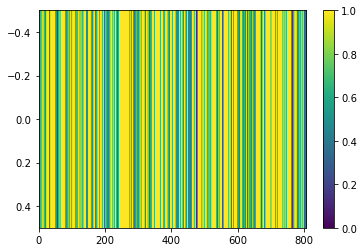

In [26]:
fitobj = list(intr_filedata.values())[0]['fitobj']
plt.imshow(np.isin(fitobj.trialsdf.index, fitobj.traininds).reshape(1, -1), aspect='auto')
plt.colorbar()

In [27]:
from ibllib.atlas import regions_from_allen_csv
from ibllib.atlas import AllenAtlas

brainregions = regions_from_allen_csv()
def get_parent_name(brainregion):
    regid = brainregions.id[np.argwhere(brainregions.acronym == brainregion)]
    ancestors = brainregions.ancestors(regid)
    targetlevel = 6
    if sum(ancestors.level == targetlevel) == 0:
        return ancestors.name[-1]
    return ancestors.name[np.argwhere(ancestors.level == targetlevel)[0, 0]]

def get_parent_acr(brainregion):
    regid = brainregions.id[np.argwhere(brainregions.acronym == brainregion)]
    ancestors = brainregions.ancestors(regid)
    targetlevel = 6
    if sum(ancestors.level == targetlevel) == 0:
        return ancestors.acronym[-1]
    return ancestors.acronym[np.argwhere(ancestors.level == targetlevel)[0, 0]]

remove = ['1', '2', '3', '4', '5', '6a', '6b', '/']
def combine_layers_cortex(regions, delete_duplicates=False):
    for i, region in enumerate(regions):
        for j, char in enumerate(remove):
            regions[i] = regions[i].replace(char, '')
    if delete_duplicates:
        regions = list(set(regions))
    return regions

def get_nolayer_name(brainregion):
    try:
        regname = brainregions.name[np.argwhere(brainregions.acronym == brainregion).flatten()][0]
        return regname
    except IndexError:
        return ''
    
all_masterscores = {}
fd_dict = {'start': start_filedata, 'middle': middle_filedata, 'end': end_filedata, 'intr': intr_filedata}
for teststr, filedata in fd_dict.items():
    for key, ses in filedata.items():
        unitdf = pd.Series(ses['fitobj'].clu_regions[ses['fitobj'].clu_ids.flat],
                       index=ses['fitobj'].clu_ids.flatten(), name='acronym')
        unitdf.index = unitdf.index.rename('cluster_id')
        ses['unit_regions'] = unitdf

    sess_strs = {s['sessinfo']['subject_nickname'] + ' from ' +
                 str(s['sessinfo']['session_start_time'].date()) + ' probe: ' +
                 str(s['sessinfo']['probe_idx']) : fn for fn, s in filedata.items()}
    orig_fns = list(filedata.keys())
    masterscores = []
    for i, fn in enumerate(filedata):
        scores = pd.DataFrame(filedata[fn]['fitobj'].score(), columns=['score'])
        regions = filedata[fn]['unit_regions'].copy()
        scores['acronym'] = regions
        scores['origfn'] = i
        scores = scores[pd.notna(scores['acronym'])]
        masterscores.append(scores)
    masterscores = pd.concat(masterscores)

    masterscores['parent_name'] = masterscores['acronym'].apply(get_parent_name)
    masterscores['parent_acronym'] = masterscores['acronym'].apply(get_parent_acr)

    masterscores['nolayer_acr'] = masterscores['acronym'].copy()
    for remstr in remove:
        masterscores['nolayer_acr'] = masterscores['nolayer_acr'].str.replace(remstr, '')
    masterscores['nolayer_name'] = masterscores.nolayer_acr.apply(get_nolayer_name)
    all_masterscores[teststr] = masterscores

/home/berk/Documents/ibllib/brainbox/modeling/glm.py:850: RuntimeWarning:

invalid value encountered in true_divide



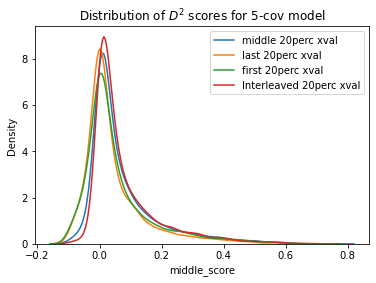

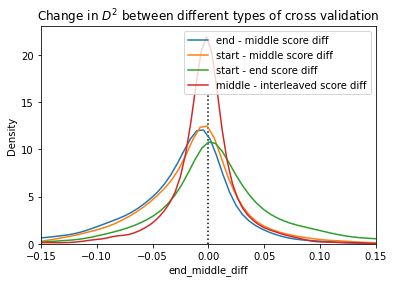

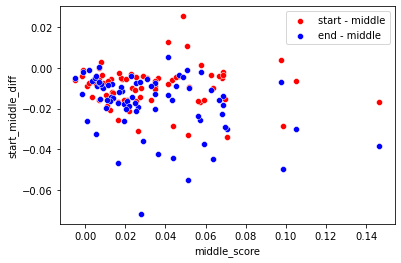

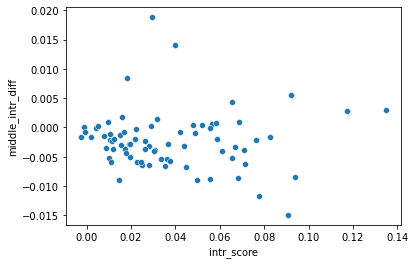

<Figure size 720x5400 with 0 Axes>

In [41]:
deluxe_masterscores = all_masterscores['start'].copy()
deluxe_masterscores.rename(columns={'score': 'start_score'}, inplace=True)
deluxe_masterscores['middle_score'] = all_masterscores['middle'].score.copy()
deluxe_masterscores['end_score'] = all_masterscores['end'].score.copy()
deluxe_masterscores['intr_score'] = all_masterscores['intr'].score.copy()
tmp_masterscores = deluxe_masterscores[(deluxe_masterscores.intr_score > -0.1) &
                                       (deluxe_masterscores.start_score > -0.1) &
                                       (deluxe_masterscores.middle_score > -0.1) &
                                       (deluxe_masterscores.end_score > -0.1)].copy()
tmp_masterscores['start_end_diff'] = tmp_masterscores['start_score'] - tmp_masterscores['end_score']
tmp_masterscores['start_middle_diff'] = tmp_masterscores['start_score'] - tmp_masterscores['middle_score']
tmp_masterscores['end_middle_diff'] = tmp_masterscores['end_score'] - tmp_masterscores['middle_score']
tmp_masterscores['middle_intr_diff'] = tmp_masterscores['middle_score'] - tmp_masterscores['intr_score']

sns.kdeplot(tmp_masterscores.middle_score, label='middle 20perc xval')
sns.kdeplot(tmp_masterscores.end_score, label='last 20perc xval')
sns.kdeplot(tmp_masterscores.start_score, label='first 20perc xval')
sns.kdeplot(tmp_masterscores.intr_score, label='Interleaved 20perc xval')
plt.legend()
plt.title(r'Distribution of $D^2$ scores for 5-cov model')

plt.figure()
sns.kdeplot(tmp_masterscores.end_middle_diff, label='end - middle score diff')
sns.kdeplot(tmp_masterscores.start_middle_diff, label='start - middle score diff')
sns.kdeplot(tmp_masterscores.start_end_diff, label='start - end score diff')
sns.kdeplot(tmp_masterscores.middle_intr_diff, label='middle - interleaved score diff')
plt.legend()
plt.title(r'Change in $D^2$ between different types of cross validation')
plt.xlim([-0.15, 0.15])
plt.vlines(0, 0, 16, color='k', ls=':')

region_counts = tmp_masterscores.nolayer_name.value_counts(sort=True, ascending=False)
topregions = region_counts.index[region_counts > 10]
grpby = tmp_masterscores[tmp_masterscores.nolayer_name.isin(topregions)].groupby('nolayer_name')
medians = grpby.agg({'middle_score': 'median', 'intr_score': 'median', 'start_middle_diff': 'median',
                     'end_middle_diff': 'median', 'start_end_diff': 'median',
                     'middle_intr_diff': 'median'})

plt.figure()
sns.scatterplot(data=medians, x='middle_score', y='start_middle_diff', color='r', label='start - middle')
sns.scatterplot(data=medians, x='middle_score', y='end_middle_diff', color='b', label='end - middle')
plt.figure()
sns.scatterplot(data=medians, x='intr_score', y='middle_intr_diff')
plt.figure(figsize=(10, len(topregions)))
dfmelt = pd.melt(tmp_masterscores, id_vars=['nolayer_name',],
                 value_vars=['middle_score', 'intr_score'], ignore_index=False)
# sns.boxenplot(medianmelt, x='value', y='')

In [42]:
dfmelt

,nolayer_name,variable,value
1,Midbrain reticular nucleus,middle_score,0.297030
2,Midbrain reticular nucleus,middle_score,0.190638
4,Midbrain reticular nucleus,middle_score,0.138604
6,Midbrain reticular nucleus,middle_score,0.373018
8,Midbrain reticular nucleus,middle_score,0.500564
...,...,...,...
653,Caudoputamen,intr_score,0.016897
657,Caudoputamen,intr_score,0.123301
660,Caudoputamen,intr_score,0.040630
662,Caudoputamen,intr_score,0.031622
